In [1]:
import os
if os.getcwd().endswith('/notebook'):
    os.chdir('..')

In [2]:
import ontonotes
from ontonotes import ontonotes_en, dev_docs, OntonotesDocument

In [3]:
import sys
def print_conllx(deps, file=sys.stdout):
    ''' 
    Convert from my custom representation back to CoNLL-X format.
    This is useful for visualization using Arne Köhn's jupyter-annodoc.
    '''
    table = [(i+1, d['token'], '_', d['pos'], d['pos'], '_', d['head']+1, d['label'], '_', '_')
             for i, d in enumerate(deps)]
    print('\n'.join('\t'.join(str(val) for val in row) 
                    for row in table))
    print()

In [32]:
import sys
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
triples = []
for doc_path in tqdm(ontonotes.list_docs(ontonotes_en)):
    if os.path.relpath(doc_path, ontonotes_en) not in dev_docs:
        doc = OntonotesDocument(doc_path)
        for sent_deps in doc.deps():
            dobjs = [d for d in sent_deps 
                     if d['label'] == 'dobj' and 
                     d['pos'].startswith('N') and 
                     d['token'] != '%']
            for dobj in dobjs:
                verb_index = dobj['head']
                verb = sent_deps[verb_index]
                sbjs = [d for d in sent_deps 
                        if d['head'] == verb_index and
                        d['pos'].startswith('N') and
                        d['token'] != '%' and
                        d['label'] in ('nsubj', 'nsubjpass', 'xsubj', 'subj')]
                for sbj in sbjs:
                    sbj_lemma = lemmatizer.lemmatize(sbj['token'], pos='n')
                    verb_lemma = lemmatizer.lemmatize(verb['token'], pos='v')
                    dobj_lemma = lemmatizer.lemmatize(dobj['token'], pos='n')
                    triples.append((sbj_lemma, verb_lemma, dobj_lemma))

100%|██████████| 13108/13108 [00:19<00:00, 684.84it/s]


In [43]:
import pandas as pd
df = pd.DataFrame(triples, columns=['sbj', 'verb', 'dobj'])
df.sample(5)

,sbj,verb,dobj
20836,country,express,admission
28442,hand,sweep,top
3515,journalist,take,newsroom
17098,Sotheby,make,guarantee
11232,planner,construct,program


In [21]:
df.describe()

,sbj,verb,dobj
count,28596,28596,28596
unique,6507,1973,5207
top,people,have,people
freq,649,2602,258


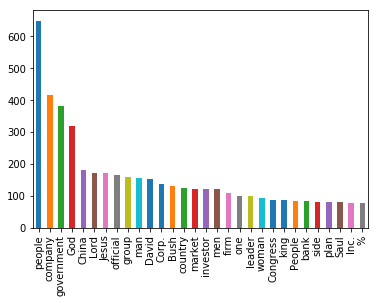

In [22]:
%matplotlib inline
df['sbj'].value_counts().head(30).plot('bar')

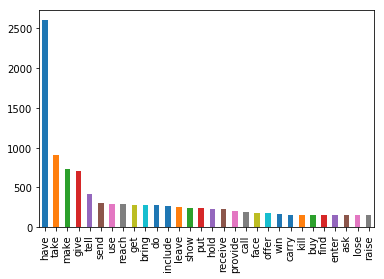

In [23]:
%matplotlib inline
df['verb'].value_counts().head(30).plot('bar')

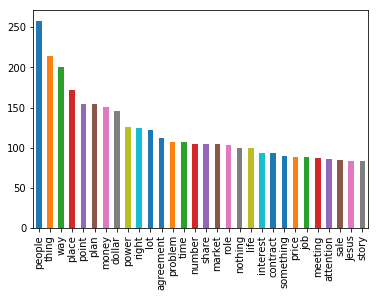

In [24]:
%matplotlib inline
df['dobj'].value_counts().head(30).plot('bar')

In [45]:
from version import version
df.to_csv('output/ontonote-svo.%s.txt' %version, 
          sep='\t', index=False, header=False)